In [1]:
## MSH analysis, calculate indicators for maps in chapter 5
## Import required modules

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
import pyproj
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from sqlalchemy import create_engine
from sqlalchemy import func

pd.set_option('display.max_columns', None)

In [2]:
## Load MHS tables
households = pd.read_csv('../../data/08_MHS/HogaresEODH2019.csv', sep = ';', decimal =',' ,
                         converters={'Id_Hogar':str,
                                     'p1_encuestador':str,
                                     'p4_nro_manzana':str,
                                     'Factor':float})
persons = pd.read_csv('../../data/08_MHS/PersonasEODH2019.csv', sep = ';', decimal =',')
vehicles = pd.read_csv('../../data/08_MHS/VehículosEODH2019.csv', sep = ';', decimal =',')
trips = pd.read_csv('../../data/08_MHS/ViajesEODH2019.csv', sep = ';', decimal =',',
                           converters={'id_hogar':str})
stages = pd.read_csv('../../data/08_MHS/EtapasEODH2019.csv', sep = ';', decimal =',')

## Load Census blocks from previous step
mgn_blocks = gpd.read_file("../../outputs/02_GOAT_inputs/blocks_with_strata_and_pop.shp")


C:\Users\rafle\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## Filter households in Bogotá, 
households_bog = households[households['municipio'] == 11001]
households_bog['total_population'] = households_bog['p7_total_personas']*households_bog['Factor']
households_bog['total_population_greater_5'] = households_bog['p8_mayores_cinco_anios']*households_bog['Factor']

## Sum vehicle columns

car_list = list(['p1mc_automovil','p1mc_pickup','p1mc_auto_servicio_especial','p1mc_motocicleta','p1mc_moto_carro','p1mc_triciclo_moto','p1mc_taxi','p1mc_camion'])
households_bog['total_motorized_vehicles'] = households_bog[car_list].sum(axis=1) * households_bog['Factor']

## Sum no of bicycles

bicycle_list = list(['p1mc_bicicleta_motor','p1mc_bicicleta_ninos','p1mc_bicicleta_sin_motor'])
households_bog['total_bicycles'] = households_bog[bicycle_list].sum(axis=1) * households_bog['Factor']

## Calculate no of walking trips per UTAM

trips['Id_Hogar'] = trips['id_hogar'].astype(str)

trips_merged = pd.merge(trips, households, how='left', on ='Id_Hogar', sort=True, suffixes=('_x', '_y')) 
trips_merged = trips_merged[trips_merged['municipio'] == 11001]
all_trips = trips_merged
trips_curve_scope = trips_merged
trips_merged = trips_merged[trips_merged['modo_principal'] == 'A pie']
trips_subset = trips_merged[['Id_Hogar','id_viaje','f_exp','Utam','Factor']]
trips_utam = trips_subset.groupby('Utam').agg(np.sum)
trips_utam['walking_trips'] = trips_utam['Factor']

## Sum by category
households_bog_subset = households_bog[['Utam','Factor','total_population','total_population_greater_5','total_motorized_vehicles','total_bicycles']]
rates_per_Utam = households_bog_subset.groupby('Utam').agg(np.sum)

## Calculate rates

rates_per_Utam['motorization_rate'] = (rates_per_Utam['total_motorized_vehicles']/rates_per_Utam['total_population_greater_5']*1000)
rates_per_Utam['bicycle_rate'] = (rates_per_Utam['total_bicycles']/rates_per_Utam['total_population_greater_5']*1000)
rates_per_Utam = pd.merge(rates_per_Utam, trips_utam, how = 'left', on = 'Utam', sort=True, indicator =True)
rates_per_Utam['Utam'] = rates_per_Utam.index   
rates_per_Utam['walking_trips_person'] = rates_per_Utam['walking_trips']/rates_per_Utam['total_population_greater_5']
rates_per_Utam = rates_per_Utam.reindex(columns=['Utam','total_population','total_population_greater_5','total_motorized_vehicles','total_bicycles','motorization_rate','bicycle_rate','walking_trips','walking_trips_person'])
rates_per_Utam

C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,Utam,total_population,total_population_greater_5,total_motorized_vehicles,total_bicycles,motorization_rate,bicycle_rate,walking_trips,walking_trips_person
Utam,,,,,,,,,
UPR1,UPR1,3537.262328,3164.281593,609.969397,1598.817336,192.767103,505.270245,1621.156627,0.512330
UPR2,UPR2,15989.078643,14699.926790,1366.256720,2928.954108,92.943097,199.249571,7860.783495,0.534750
UPR3,UPR3,12047.812459,10733.970244,1107.908026,1638.905026,103.215120,152.683955,10689.073680,0.995817
UTAM1,UTAM1,1998.290382,1902.844236,401.836202,979.901506,211.176613,514.966747,1327.600352,0.697693
UTAM10,UTAM10,32499.959942,31112.714039,7907.531846,11991.140320,254.157572,385.409653,15480.855168,0.497573
...,...,...,...,...,...,...,...,...,...
UTAM95,UTAM95,22917.964647,21594.019436,1833.855368,4839.008005,84.924225,224.090194,20101.866072,0.930900
UTAM96,UTAM96,50643.518357,48056.391998,5349.867091,6142.652659,111.324776,127.821761,48230.505064,1.003623
UTAM97,UTAM97,33768.467106,32836.724701,10290.968408,13740.708088,313.398139,418.455501,28180.851060,0.858211


In [6]:
all_trips.to_csv('../../outputs/03_trips/bogota_trips_v00.csv')

In [9]:
trips['Id_Hogar'] = trips['id_hogar'].astype(str)

## Merge household data to trips and filter trips from households in Bogotá
trips_merged = pd.merge(trips, households, how='left', on ='Id_Hogar', sort=True, suffixes=('_x', '_y')) 
trips_merged = trips_merged[trips_merged['municipio'] == 11001]

## Summarize trips from all modes
trips_utam_all = trips_merged.groupby('Utam').agg(np.sum)
trips_utam_all['Utam'] = trips_utam_all.index
trips_utam_all['Total_trips'] = trips_utam_all['Factor']
trips_utam_all = trips_utam_all[['Utam','Total_trips']]
trips_utam_all.index.name = None

## Summarize cycling trips

trips_utam_cycling = trips_merged[trips_merged['modo_principal'] == 'Bicicleta']
trips_utam_cycling = trips_utam_cycling[['Utam','Factor']]
trips_utam_cycling = trips_utam_cycling.groupby('Utam').agg(np.sum)
trips_utam_cycling['Utam'] = trips_utam_cycling.index
trips_utam_cycling['Cycling_trips'] = trips_utam_cycling['Factor']
trips_utam_cycling = trips_utam_cycling[['Utam','Cycling_trips']]
trips_utam_cycling.index.name = None

## Summarize TM trips
trips_utam_TM = trips_merged[trips_merged['modo_principal'] == 'TransMilenio']
trips_utam_TM = trips_utam_TM[['Utam','Factor']]
trips_utam_TM = trips_utam_TM.groupby('Utam').agg(np.sum)
trips_utam_TM['Utam'] = trips_utam_TM.index
trips_utam_TM['TM_trips'] = trips_utam_TM['Factor']
trips_utam_TM = trips_utam_TM[['Utam','TM_trips']]
trips_utam_TM.index.name = None

## Summarize SITP trips
trips_utam_SITP = trips_merged[trips_merged['modo_principal'] == 'SITP Zonal']
trips_utam_SITP = trips_utam_SITP[['Utam','Factor']]
trips_utam_SITP = trips_utam_SITP.groupby('Utam').agg(np.sum)
trips_utam_SITP['Utam'] = trips_utam_SITP.index
trips_utam_SITP['SITP_trips'] = trips_utam_SITP['Factor']
trips_utam_SITP = trips_utam_SITP[['Utam','SITP_trips']]
trips_utam_SITP.index.name = None

## Summarize pedestrian trips 

trips_utam_walking = trips_merged[trips_merged['modo_principal'] == 'A pie']
trips_utam_walking = trips_utam_walking[['Utam','Factor']]
trips_utam_walking = trips_utam_walking.groupby('Utam').agg(np.sum)
trips_utam_walking['Utam'] = trips_utam_walking.index
trips_utam_walking['Walking_trips'] = trips_utam_walking['Factor']
trips_utam_walking = trips_utam_walking[['Utam','Walking_trips']]
trips_utam_walking.index.name = None
## Merge all trips
trips_total_utam = pd.merge(trips_utam_all, trips_utam_cycling, how = 'left', on = 'Utam', sort=True)
trips_total_utam = pd.merge(trips_total_utam, trips_utam_walking, how = 'left', on = 'Utam', sort=True)
trips_total_utam = pd.merge(trips_total_utam, trips_utam_TM, how = 'left', on = 'Utam', sort=True)
trips_total_utam = pd.merge(trips_total_utam, trips_utam_SITP, how = 'left', on = 'Utam', sort=True)
trips_total_utam.index.name = None
rates_per_Utam.index.name = None
## Merge with rates per UTAM, to sum up all the indicators
utams  = pd.merge(rates_per_Utam, trips_total_utam, how = 'left', on = 'Utam', sort=True)
utams['pedestrian_share'] = utams['walking_trips']/utams['Total_trips']
utams['cycling_share'] = utams['Cycling_trips']/utams['Total_trips']
utams['transmilenio_share'] = utams['TM_trips']/utams['Total_trips']
utams['SITP_share'] = utams['SITP_trips']/utams['Total_trips']
utams['cycling_trips_person'] = utams['Cycling_trips']/ utams['total_population_greater_5']
utams['pt_trips_person'] = (utams['SITP_trips']+utams['TM_trips'])/ utams['total_population_greater_5']

##

utams = utams[['Utam','motorization_rate','bicycle_rate','walking_trips_person','pedestrian_share','cycling_share','transmilenio_share','SITP_share','cycling_trips_person','pt_trips_person']]
utams
#trips_total_utam

,Utam,motorization_rate,bicycle_rate,walking_trips_person,pedestrian_share,cycling_share,transmilenio_share,SITP_share,cycling_trips_person,pt_trips_person
0,UPR1,192.767103,505.270245,0.512330,0.295851,0.147707,0.183828,0.033051,0.255786,0.375571
1,UPR2,92.943097,199.249571,0.534750,0.312285,0.018076,0.106730,0.233226,0.030953,0.582135
2,UPR3,103.215120,152.683955,0.995817,0.468142,0.010169,0.077861,0.151810,0.021632,0.488549
3,UTAM1,211.176613,514.966747,0.697693,0.345859,0.171706,0.105951,0.006745,0.346379,0.227338
4,UTAM10,254.157572,385.409653,0.497573,0.212583,0.028278,0.214271,0.088501,0.066188,0.708671
5,UTAM100,190.566555,328.443231,0.819721,0.366416,0.097050,0.125151,0.073015,0.217114,0.443324
6,UTAM101,233.310552,370.137136,0.693949,0.342667,0.090758,0.114794,0.050959,0.183797,0.335672
7,UTAM102,166.493440,318.212599,0.869559,0.412824,0.069274,0.124882,0.062044,0.145917,0.393733
8,UTAM103,272.382991,443.771225,0.396396,0.173112,0.088941,0.072214,0.115968,0.203659,0.430905
9,UTAM104,282.365598,295.565635,0.439430,0.210225,0.034332,0.084080,0.064157,0.071763,0.309858


In [10]:
## OD matrix for desire lines

trips_merged = pd.merge(trips, households, how='left', on ='Id_Hogar', sort=True, suffixes=('_x', '_y')) 
trips_merged = trips_merged[trips_merged['municipio'] == 11001]

## Filter walking trips
trips_merged_walking = trips_merged[trips_merged['modo_principal'] == 'A pie']
matrix_trips = trips_merged_walking.groupby(['zat_origen','zat_destino'])['Factor'].sum()
matrix_trips = pd.DataFrame(matrix_trips)
matrix_trips = matrix_trips.rename(columns ={'Factor':'walking_trips'})

## Filter cycling trips
trips_merged_cycling = trips_merged[trips_merged['modo_principal']== 'Bicicleta']
matrix_cycling = trips_merged_cycling.groupby(['zat_origen','zat_destino'])['Factor'].sum()
matrix_cycling = pd.DataFrame(matrix_cycling)
matrix_cycling = matrix_cycling.rename(columns = {'Factor':'cycling_trips'})

## Join both matrices in the same list

matrix = pd.merge(matrix_trips, matrix_cycling, how= 'outer', on = ['zat_origen','zat_destino'], sort=True)

matrix = matrix.fillna(0)
matrix = matrix.round(2)
matrix = matrix.reset_index()

matrix = matrix.rename(columns ={'zat_origen':'origin_zone','zat_destino':'destination_zone'})


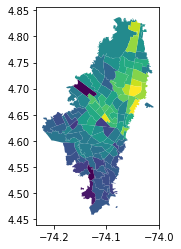

In [21]:
## Load UTAM and ZAT shapefile 
utams_shapefile = gpd.read_file("../../data/08_MHS/shp/UTAM.shp")
zat_shapefile = gpd.read_file("../../data/08_MHS/shp/ZAT.shp", encoding='utf-8')
utams_shapefile['Utam'] = utams_shapefile['UTAM']

## Join data to UTAM

utams_shapefile = pd.merge(utams, utams_shapefile, how = 'right', on ='Utam', sort= True)

utams_shapefile = utams_shapefile.set_geometry('geometry')
#utams_shapefile = utams_shapefile.set_crs(epsg=4326)

## Filter UPR2 to 5 and non Bogotá zones from UTAM

utams_shapefile = utams_shapefile.drop(utams_shapefile[utams_shapefile.Utam == 'UPR2'].index)
utams_shapefile = utams_shapefile.drop(utams_shapefile[utams_shapefile.Utam == 'UPR3'].index)
utams_shapefile = utams_shapefile.drop(utams_shapefile[utams_shapefile.Utam == 'UPR4'].index)
utams_shapefile = utams_shapefile.drop(utams_shapefile[utams_shapefile.Utam == 'UPR5'].index)
utams_shapefile = utams_shapefile.drop(utams_shapefile[utams_shapefile.MUNNombre != 'BOGOTA'].index)

utams_shapefile = utams_shapefile.fillna(0)

## Filter UPR2 to 5 and non Bogotá zones from TAZ

zat_shapefile = zat_shapefile.drop(zat_shapefile[zat_shapefile.NOMMun != 'Bogotá'].index)
zat_shapefile = zat_shapefile.drop(zat_shapefile[zat_shapefile.UTAM == 'UPR3'].index)
zat_shapefile = zat_shapefile.drop(zat_shapefile[zat_shapefile.UTAM == 'UPR2'].index)

## Export to outputs

matrix.to_csv("../../outputs/02_GOAT_inputs/pedestrian_walking_trips.csv")

utams_shapefile.plot(column = 'motorization_rate')

utams_shapefile.to_file("../../outputs/02_GOAT_inputs/utams_trips.shp")
utams_shapefile.to_file("../../outputs/02_GOAT_inputs/study_area.shp")
zat_shapefile.to_file("../../outputs/02_GOAT_inputs/taz.shp")
